In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn

from skimage import io
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

random_state = 42
gen = random.Random(random_state)

trimmed = False
data_dir = '../../allwavs/allvowl/corrected/extracted/' + 'trimmed/'*trimmed + 'img/'
files = os.listdir(data_dir)
#max_w = max(io.imread(data_dir + '/' + file).shape[1] for file in files)
#print(max_w)
max_w = 781 if not trimmed else 513# Measured
# max_w = 1165 if not trimmed else 643# Measured
use_mel = True
files = [file for file in files if ('mel' in file) == use_mel]
gen.shuffle(files)

In [2]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [3]:
class SpectrumDataset(Dataset):
    def __init__(self, data_dir, files):
        self.data_dir = data_dir
        self.files = [file for file in files if '~' not in file.split('__')[0]]
        gen.shuffle(self.files)
        self.idx2lbl = ['2', '9', 'a', 'E', 'e', 'i', 'o', 'O', 'u', 'y']
        self.lbl2idx = {label: i for i, label in enumerate(self.idx2lbl)}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_np = io.imread(self.data_dir + '/' + self.files[idx], as_gray=True)
        image_np = np.pad(1 - image_np, [(0, 0), (0, max_w - image_np.shape[1])], mode='constant', constant_values=0)
        label = self.files[idx].split('__')[0].replace('E+', 'e').replace('@', '2')
        return (torch.tensor(image_np).float(), self.lbl2idx[label])

l = len(files)
train_size = 0.9
cutoff = int(l*train_size)

train_set = SpectrumDataset(data_dir, files[:cutoff])
test_set = SpectrumDataset(data_dir, files[cutoff:])

Text(0.5, 1.0, '0')

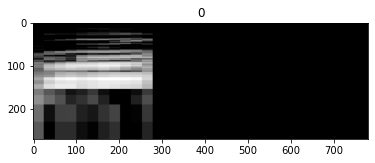

In [4]:
im, label = train_set[0]
plt.imshow(im.numpy(), cmap='gray')
plt.title(label)

In [5]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNClassifier, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3),
                                        nn.ReLU(),
                                        #nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=3))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3),
                                        nn.ReLU(),
                                        #nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=3))
        self.dropout = nn.Dropout(0.3)
        self.linear_layer1 = nn.Sequential(nn.Linear(32*29*(56 if trimmed else 85), 64),
        nn.ReLU())
        self.linear_layer2 = nn.Sequential(nn.Linear(64, num_classes))
        
        #self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
        #                                nn.ReLU(),
        #                                #nn.BatchNorm2d(16),
        #                                nn.MaxPool2d(kernel_size=5))
        #self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
        #                                nn.ReLU(),
        #                                #nn.BatchNorm2d(32),
        #                                nn.MaxPool2d(kernel_size=5))
        #self.linear_layer1 = nn.Linear(32*10*25, num_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        out1 = self.cnn_layer1(x)
        out2 = self.cnn_layer2(out1)
        #out2 = self.dropout(out2)
        out_vec = out2.reshape(out2.shape[0], -1)
        out = self.linear_layer1(out_vec)
        out2 = self.linear_layer2(out)
        return out#2

In [6]:
def eval_cnn_classifier(model, eval_dataloader):
    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            images = images.cuda()
            labels = labels.cuda()
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    model_tr = copy.deepcopy(model)
    model_tr.train()
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    loss_all_epochs = []
    test_acc_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: N/A, Test acc: {eval_cnn_classifier(model_tr, test_dataloader):.4f}%')
    
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for batch_index, (images, labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            images = images.cuda()
            labels = labels.cuda()
            pred_labels = model_tr(images)

            loss = loss_fn(pred_labels, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch)
        test_acc = eval_cnn_classifier(model_tr, test_dataloader)
        test_acc_all_epochs.append(test_acc)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_current_epoch:.4f}, Test acc: {test_acc:.4f}%')
        
    return model_tr, loss_all_epochs, test_acc_all_epochs

Total number of parameters:  5053834
Epoch [0/15], Loss: N/A, Test acc: 0.2415%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:40<00:00, 36.54it/s]


Epoch [1/15], Loss: 7416.8929, Test acc: 61.8357%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.50it/s]


Epoch [2/15], Loss: 4233.0051, Test acc: 66.6667%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:23<00:00, 44.14it/s]


Epoch [3/15], Loss: 2479.3942, Test acc: 70.0483%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.25it/s]


Epoch [4/15], Loss: 1715.4466, Test acc: 67.6329%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.52it/s]


Epoch [5/15], Loss: 1238.4654, Test acc: 67.8744%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.34it/s]


Epoch [6/15], Loss: 929.6899, Test acc: 69.5652%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:25<00:00, 42.87it/s]


Epoch [7/15], Loss: 681.0368, Test acc: 68.8406%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:24<00:00, 43.61it/s]


Epoch [8/15], Loss: 483.8822, Test acc: 69.8068%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.46it/s]


Epoch [9/15], Loss: 461.9411, Test acc: 68.3575%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.39it/s]


Epoch [10/15], Loss: 347.0500, Test acc: 68.8406%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:24<00:00, 43.67it/s]


Epoch [11/15], Loss: 288.4045, Test acc: 71.0145%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:23<00:00, 44.02it/s]


Epoch [12/15], Loss: 239.9330, Test acc: 71.0145%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.24it/s]


Epoch [13/15], Loss: 54.8029, Test acc: 71.7391%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.39it/s]


Epoch [14/15], Loss: 135.6611, Test acc: 69.8068%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3671/3671 [01:22<00:00, 44.28it/s]


Epoch [15/15], Loss: 68.0607, Test acc: 72.9469%


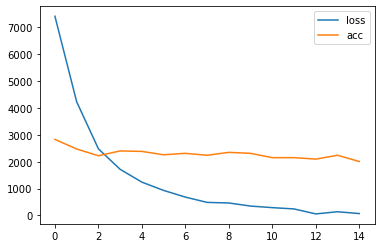

In [7]:
batch_size = 1
train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

num_classes = 10
model = CNNClassifier(num_classes)

print('Total number of parameters: ', 
      sum(p.numel() for p in model.parameters()))

torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 15
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01

model.cuda()
model, loss_total, test_acc_total = training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True)

torch.save(model.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total, label='loss')
plt.plot([max(loss_total)*(100-x)/100 for x in test_acc_total], label='acc')
plt.legend()
plt.show()

In [33]:
acc = eval_cnn_classifier(model, test_dataloader)
print(acc)

76.10837438423646


              precision    recall  f1-score   support

           2     0.8108    0.7143    0.7595        42
           9     0.7179    0.8235    0.7671        34
           a     0.8571    0.9333    0.8936        45
           E     0.6418    0.6515    0.6466        66
           e     0.2917    0.3500    0.3182        20
           i     0.8182    0.7500    0.7826        36
           O     0.6667    0.8148    0.7333        27
           o     0.8222    0.7551    0.7872        49
           u     0.7857    0.7174    0.7500        46
           y     0.7333    0.6735    0.7021        49

    accuracy                         0.7295       414
   macro avg     0.7145    0.7183    0.7140       414
weighted avg     0.7368    0.7295    0.7311       414



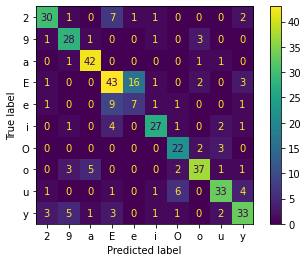

In [8]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.cuda()
        labels = labels.cuda()
        y_predicted = model(images)
        _, label_predicted = torch.max(y_predicted.data, 1)
        y_pred.append(label_predicted.item())
        y_true.append(labels.item())

        
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
target_names = ['2', '9', 'a', 'E', 'e', 'i', 'O', 'o', 'u', 'y']
print(classification_report(y_true, y_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()